# **Brain Abnormality Classification**



In this notebook we are going to train a CNN-based model for a multi-class classification task, brain abnormality classification. The dataset we are going to use is a small imbalanced one that contains MRIs of both normal and abnormal brains.
We will learn how to use and refine models that have been already trained on some other rich datasets to deal with situations in which we don't have access to good datasets or powerful hardware.

# Imports

In [152]:
from __future__ import print_function
from __future__ import division
import imgaug
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision
from torchvision import datasets, models
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import shutil
import os
import random
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


# 1) Data Preparation:

## 1.1) Download Dataset

In [ ]:
!wget --content-disposition https://figshare.com/ndownloader/files/28399209
!mkdir dataset
!tar xvf NINS_Dataset.tar --directory dataset/

In [3]:
data_dir = 'dataset/'

classes = os.listdir(data_dir)
shutil.rmtree(os.path.join(data_dir, 'models'))
classes = os.listdir(data_dir)

for c in classes:
    images = os.listdir(os.path.join(data_dir, c))
    for image in images:
      if image[-4:] != '.jpg':
        corrupted_img = os.path.join(data_dir, c, image)
        try:
          os.remove(corrupted_img)
        except:
          shutil.rmtree(corrupted_img)

## 1.2) Splitting Dataset:

In [4]:
root_dir = 'dataset'
classes = os.listdir(root_dir)

train_split = 0.7
val_split = 0.1
test_split = 0.2

data_dict = {}
for idx, class_name in enumerate(classes):
    class_dir = os.path.join(root_dir, class_name)
    data_dict[class_name] = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

train_images = []
val_images = []
test_images = []
for cls_name, images in data_dict.items():
  print(cls_name, ':', len(images))
  n = len(images)
  train = np.random.choice(images, int(train_split * n), replace=False)
  images = list(set(images) - set(train))
  val = np.random.choice(images, int(val_split * n), replace=False)
  test = list(set(images) - set(val))
  train_images += list(train)
  val_images += list(val)
  test_images += test

Encephalomalacia with gliotic change : 76
cerebral venous sinus thrombosis : 76
Small Vessel Diease Demyelination : 38
Microvascular ischemic change : 72
meningioma : 76
NMOSD  ADEM : 36
Postoperative encephalomalacia : 38
Brain Atrophy : 264
Obstructive Hydrocephalus : 76
Cerebral Hemorrhage : 36
Brain Tumor (Ependymoma) : 36
Hemorrhagic collection : 38
Brain Tumor (Hemangioblastoma  Pleomorphic xanthroastrocytoma  metastasis) : 74
Normal : 1749
Mid triventricular hydrocephalus : 38
Stroke(infarct) : 906
Brain tumor - Recurrenceremnant of previous lesion : 114
Brain Infection : 38
Glioma : 76
Brain tumor (Dermoid cyst craniopharyngioma) : 38
pituitary tumor : 76
Cerebral abscess : 36
small meningioma : 36
Brain Infection with abscess : 76
Post-operative Status with Small Hemorrhage : 38
Stroke (Haemorrhage) : 564
Malformation (Chiari I) : 38
Left Retro-orbital Haemangioma : 112
Ischemic change  demyelinating plaque : 38
Leukoencephalopathy with subcortical cysts : 38
White Matter Dise

37 classes

The minimum and maximum size for classes are 36 and 1749, respectivley.

### Separating Data Folders

In [5]:
!mkdir train val test

n_img = 0
for image in train_images:
  n_img += 1
  os.makedirs(os.path.join('train', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('train', *image.split('/')[1:]))

for image in val_images:
  os.makedirs(os.path.join('val', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('val', *image.split('/')[1:]))

for image in test_images:
  os.makedirs(os.path.join('test', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('test', *image.split('/')[1:]))

## 1.3) Calculate Weights of Calsses:

As you saw there exists an imbalance between classes. The dataset contains a class with more than a thousand samples and classes with fewer than 50 samples.

Here we want to calculate coefficients (weights) that can compensate this gap. So we are supposed to calculate these coefficients for each class such that if we multiply a class size by its corresponding coefficient the result will be equal for all the other classes. The minimum value of a coefficient should be 1.

In [6]:
wgts = []
max_size = max([len(i) for i in data_dict.values()])

for c in classes:
  print(c)
  n_sample_c = len(data_dict[c])

  w = max_size / n_sample_c
  wgts.append(w)
  print('Size of Class: ' + str(n_sample_c))
  print('Weight of Class: ' + str(w))
  print()

wgts = torch.Tensor(wgts)

Encephalomalacia with gliotic change
Size of Class: 76
Weight of Class: 23.013157894736842

cerebral venous sinus thrombosis
Size of Class: 76
Weight of Class: 23.013157894736842

Small Vessel Diease Demyelination
Size of Class: 38
Weight of Class: 46.026315789473685

Microvascular ischemic change
Size of Class: 72
Weight of Class: 24.291666666666668

meningioma
Size of Class: 76
Weight of Class: 23.013157894736842

NMOSD  ADEM
Size of Class: 36
Weight of Class: 48.583333333333336

Postoperative encephalomalacia
Size of Class: 38
Weight of Class: 46.026315789473685

Brain Atrophy
Size of Class: 264
Weight of Class: 6.625

Obstructive Hydrocephalus
Size of Class: 76
Weight of Class: 23.013157894736842

Cerebral Hemorrhage
Size of Class: 36
Weight of Class: 48.583333333333336

Brain Tumor (Ependymoma)
Size of Class: 36
Weight of Class: 48.583333333333336

Hemorrhagic collection
Size of Class: 38
Weight of Class: 46.026315789473685

Brain Tumor (Hemangioblastoma  Pleomorphic xanthroastroc

## 1.4) Create DataLoaders:

In [9]:
train_images = []
train_aug_images = []
val_images = []
test_images = []

for c in classes:
    class_dir = os.path.join('train', c)
    train_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('val', c)
    val_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('test', c)
    test_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

**Note:** Typical input image sizes to a Convolutional Neural Network trained on are 224×224, 227×227, 256×256, and 299×299. VGG16, VGG19, and ResNet all accept 224×224 input images while Inception V3 and Xception require 299×299 pixel inputs.

In [10]:
class CustomDataset(Dataset):
    def __init__(self, image_list, classes=None, transform=None):
        self.image_list = image_list
        self.transform = transform
        self.label_encoder = {c: i for (i, c) in enumerate(classes)}

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image = Image.open(self.image_list[index])

        if self.transform is not None:
            image = self.transform(image)

        label = self.image_list[index].split('/')[-2]
        label = self.label_encoder[label]

        return image, label


transform = T.Compose([
    T.Resize((224, 224)),
    T.Grayscale(3),
    T.ToTensor()
])

train_dataset = CustomDataset(train_images, classes, transform)
val_dataset = CustomDataset(val_images, classes, transform)
test_dataset = CustomDataset(test_images, classes, transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [11]:
data_loaders = {'train': train_loader, 'val': val_loader}
num_cls = len(classes)

## 1.2) Data Visualization

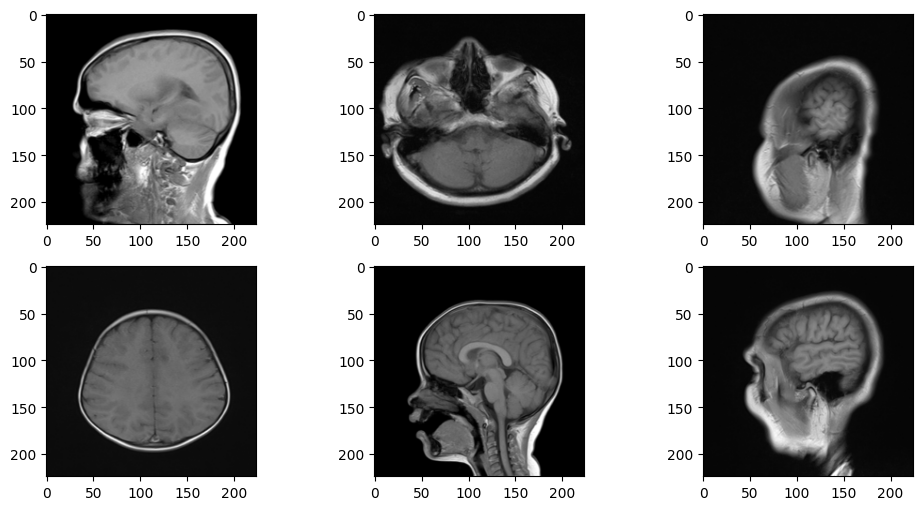

In [12]:
fig, axis = plt.subplots(2, 3, figsize=(12, 6))
for i, batch in enumerate(train_loader):
  axis[0, 0].imshow(np.array(batch[0][0]).transpose(1, 2, 0))
  axis[0, 1].imshow(np.array(batch[0][1]).transpose(1, 2, 0))
  axis[0, 2].imshow(np.array(batch[0][2]).transpose(1, 2, 0))
  axis[1, 0].imshow(np.array(batch[0][-3]).transpose(1, 2, 0),)
  axis[1, 1].imshow(np.array(batch[0][-2]).transpose(1, 2, 0),)
  axis[1, 2].imshow(np.array(batch[0][-1]).transpose(1, 2, 0),)
  break

# 2) Model Initialization and Structure Modification


## 2.1) ResNet50:

In [ ]:
resnet_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
print(resnet_model)

**Note:** last layer (4) is used for classification. we can see Convolutional and Fully connected layers in it. The last fc layer is using extracted features from previous layers to predict 1000 classes.

Modifying the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [14]:
class CustomResnet(nn.Module):
  def __init__(self, resnet_model, classes):
    super().__init__()
    self.resnet = nn.Sequential(*list(resnet_model.children())[:-1])
    self.fc = nn.Linear(2048, classes)

  def forward(self, input):
    x = self.resnet(input)
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

In [ ]:
resnet_model = CustomResnet(resnet_model, num_cls)
print(resnet_model)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

## 2.2) VGG16:

In [ ]:
vgg_model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
print(vgg_model)

**Note:** As it is written in last layer (classifier) it will be used for classification. In classifier layer we can see that it has 3 fully connected layers with ReLU activation function and dropout regularization.

Modifying the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [18]:
class CustomVGG(nn.Module):
  def __init__(self, vgg_model, classes):
    super().__init__()
    self.vgg = nn.Sequential(*list(vgg_model.children())[:-1])
    self.vgg_classifier = nn.Sequential(*list((list(vgg_model.children())[-1]).children())[:-1])
    self.fc = nn.Linear(4096, classes)

  def forward(self, input):
    x = self.vgg(input)
    x = torch.flatten(x, 1)
    x = self.vgg_classifier(x)
    x = self.fc(x)
    return x

In [ ]:
vgg_model = CustomVGG(vgg_model, num_cls)
print(vgg_model)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg_model = vgg_model.to(device)

# 3) Train Function:

In [21]:
wgts = wgts.to(device)
criterion = nn.CrossEntropyLoss(weight=wgts)

In [22]:
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10):
    since = time.time()

    acc_hist = { 'train': [], 'val': [] }
    loss_hist = { 'train': [], 'val': [] }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterating over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):

                    # Calculating outputs, predictions, and losses
                    pred_l = model(inputs)
                    loss = criterion(pred_l, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() # Summation of losses
                running_corrects += sum(torch.argmax(pred_l, dim=1) == labels).item() # Summation of true classifications

            epoch_loss = running_loss / len(dataloaders[phase]) # Average of losses. Use running_loss
            epoch_acc = running_corrects / (len(dataloaders[phase]) * data_loaders[phase].batch_size) * 100 # Accuracy. Use running_corrects

            # if phase == 'val' and not(scheduler is None):
            #     ... # Set scheduler

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            acc_hist[phase].append(epoch_acc)
            loss_hist[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # loading best model weights with the stored state dictionary
    model = model.load_state_dict(best_model_wts)

    return model, acc_hist, loss_hist

# 4) Feature Extraction


### 4.1) ResNet50

### 4.1.1) Freezing:

In [23]:
for child in resnet_model.children():
  for param in child.parameters():
    param.requires_grad = False
  break

### 4.1.2) Training:

In [24]:
epochs = 30

In [37]:
resnet_optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)

# lr_scheduler = None

In [38]:
resnet_fe, resnet_acc_fe, resnet_loss_fe = train_model(resnet_model, data_loaders, criterion, resnet_optimizer, scheduler=None, num_epochs=epochs)

Epoch 0/29
----------
train Loss: 3.3653 Acc: 10.2909
val Loss: 3.4099 Acc: 9.9010

Epoch 1/29
----------
train Loss: 2.9364 Acc: 24.7575
val Loss: 3.2386 Acc: 19.2079

Epoch 2/29
----------
train Loss: 2.6173 Acc: 29.0679
val Loss: 3.1300 Acc: 19.6040

Epoch 3/29
----------
train Loss: 2.3545 Acc: 33.1358
val Loss: 3.1136 Acc: 19.2079

Epoch 4/29
----------
train Loss: 2.1157 Acc: 36.3416
val Loss: 3.0278 Acc: 19.8020

Epoch 5/29
----------
train Loss: 1.9333 Acc: 37.7963
val Loss: 2.8405 Acc: 26.9307

Epoch 6/29
----------
train Loss: 1.7547 Acc: 42.1875
val Loss: 2.8160 Acc: 23.9604

Epoch 7/29
----------
train Loss: 1.5979 Acc: 42.0797
val Loss: 2.7610 Acc: 24.3564

Epoch 8/29
----------
train Loss: 1.4872 Acc: 45.2856
val Loss: 2.7446 Acc: 25.9406

Epoch 9/29
----------
train Loss: 1.3737 Acc: 47.4407
val Loss: 2.6372 Acc: 27.9208

Epoch 10/29
----------
train Loss: 1.2585 Acc: 47.4946
val Loss: 2.6195 Acc: 29.9010

Epoch 11/29
----------
train Loss: 1.1827 Acc: 50.8890
val Loss: 

### 4.2) VGG16

### 4.2.1) Freezing:

In [39]:
for i, child in enumerate(vgg_model.children()):
  if i == 2:
    break
  for param in child.parameters():
    param.requires_grad = False

### 4.2.2) Training:

In [40]:
vgg_optimizer = torch.optim.Adam(vgg_model.parameters(), lr=0.001)
# lr_scheduler = None

In [41]:
vgg_fe, vgg_acc_fe, vgg_loss_fe = train_model(vgg_model, data_loaders, criterion, vgg_optimizer, scheduler=lr_scheduler, num_epochs=epochs)

Epoch 0/29
----------
train Loss: 3.7406 Acc: 2.9364
val Loss: 3.6324 Acc: 3.9604

Epoch 1/29
----------
train Loss: 3.1374 Acc: 7.7317
val Loss: 3.3743 Acc: 8.3168

Epoch 2/29
----------
train Loss: 2.8079 Acc: 11.7188
val Loss: 3.4034 Acc: 6.7327

Epoch 3/29
----------
train Loss: 2.6292 Acc: 13.4698
val Loss: 3.2925 Acc: 7.3267

Epoch 4/29
----------
train Loss: 2.4588 Acc: 14.5205
val Loss: 3.2826 Acc: 8.9109

Epoch 5/29
----------
train Loss: 2.3302 Acc: 15.5981
val Loss: 3.2764 Acc: 12.0792

Epoch 6/29
----------
train Loss: 2.2478 Acc: 17.7263
val Loss: 3.2202 Acc: 9.9010

Epoch 7/29
----------
train Loss: 2.1102 Acc: 18.4537
val Loss: 3.1633 Acc: 10.8911

Epoch 8/29
----------
train Loss: 2.0466 Acc: 19.1002
val Loss: 3.2147 Acc: 12.4752

Epoch 9/29
----------
train Loss: 2.0122 Acc: 19.4504
val Loss: 2.8651 Acc: 16.0396

Epoch 10/29
----------
train Loss: 1.9448 Acc: 21.2823
val Loss: 3.2134 Acc: 13.2673

Epoch 11/29
----------
train Loss: 1.8576 Acc: 21.2015
val Loss: 2.9028 

# 5) Fine-Tuning


In [50]:
epochs = 16

## 5.1) ResNet50

### 5.1.1) Unfreezing

In [42]:
for param in resnet_model.parameters():
  param.requires_grad = True

### 5.1.2) Train the Model:

In [51]:
resnet_optimizer = torch.optim.Adam([
                                      {'params': resnet_model.resnet.parameters()},
                                      {'params': resnet_model.fc.parameters(), 'lr': 1e-3}
                                    ], lr=1e-4)

# lr_scheduler = None

resnet_ft, resnet_acc_ft, resnet_loss_ft = train_model(resnet_model, data_loaders, criterion, resnet_optimizer, scheduler=None, num_epochs=epochs)

Epoch 0/11
----------
train Loss: 0.0013 Acc: 99.0302
val Loss: 0.5818 Acc: 84.9505

Epoch 1/11
----------
train Loss: 0.0006 Acc: 99.1649
val Loss: 0.6213 Acc: 84.1584

Epoch 2/11
----------
train Loss: 0.0006 Acc: 99.2188
val Loss: 0.8174 Acc: 80.3960

Epoch 3/11
----------
train Loss: 0.0031 Acc: 98.9494
val Loss: 2.4478 Acc: 62.7723

Epoch 4/11
----------
train Loss: 0.0077 Acc: 98.5183
val Loss: 0.8685 Acc: 79.8020

Epoch 5/11
----------
train Loss: 0.0216 Acc: 98.1142
val Loss: 0.7783 Acc: 80.3960

Epoch 6/11
----------
train Loss: 0.0442 Acc: 96.7134
val Loss: 1.2063 Acc: 74.0594

Epoch 7/11
----------
train Loss: 0.0238 Acc: 95.8244
val Loss: 0.7081 Acc: 82.3762

Epoch 8/11
----------
train Loss: 0.0035 Acc: 98.9763
val Loss: 0.5147 Acc: 85.5446

Epoch 9/11
----------
train Loss: 0.0011 Acc: 99.1379
val Loss: 0.4984 Acc: 88.3168

Epoch 10/11
----------
train Loss: 0.0006 Acc: 99.2457
val Loss: 0.4978 Acc: 88.1188

Epoch 11/11
----------
train Loss: 0.0004 Acc: 99.2457
val Loss:

## 5.2) VGG16

### 5.2.1) Unfreezing

In [52]:
for param in vgg_model.parameters():
  param.requires_grad = True

### 5.2.2) Train the Model:

In [53]:
vgg_optimizer = torch.optim.Adam([
                                      {'params': vgg_model.vgg.parameters()},
                                      {'params': vgg_model.vgg_classifier.parameters()},
                                      {'params': vgg_model.fc.parameters(), 'lr': 1e-3}
                                  ], lr=1e-4)

# lr_schedular = None

vgg_ft, vgg_acc_ft, vgg_loss_ft = train_model(vgg_model, data_loaders, criterion, vgg_optimizer, scheduler=lr_scheduler, num_epochs=epochs)

Epoch 0/11
----------
train Loss: 2.9150 Acc: 10.4526
val Loss: 3.0512 Acc: 15.2475

Epoch 1/11
----------
train Loss: 1.3229 Acc: 28.6638
val Loss: 2.5668 Acc: 27.3267

Epoch 2/11
----------
train Loss: 0.7054 Acc: 42.4030
val Loss: 2.1101 Acc: 35.2475

Epoch 3/11
----------
train Loss: 0.4802 Acc: 51.1315
val Loss: 2.1022 Acc: 35.8416

Epoch 4/11
----------
train Loss: 0.3434 Acc: 58.8093
val Loss: 2.1329 Acc: 41.9802

Epoch 5/11
----------
train Loss: 0.3235 Acc: 58.5668
val Loss: 1.4018 Acc: 54.0594

Epoch 6/11
----------
train Loss: 0.2118 Acc: 67.6994
val Loss: 1.2566 Acc: 60.7921

Epoch 7/11
----------
train Loss: 0.1362 Acc: 73.8147
val Loss: 1.6060 Acc: 52.6733

Epoch 8/11
----------
train Loss: 0.1166 Acc: 76.9397
val Loss: 1.2005 Acc: 63.9604

Epoch 9/11
----------
train Loss: 0.1391 Acc: 79.0409
val Loss: 1.1260 Acc: 61.9802

Epoch 10/11
----------
train Loss: 0.1494 Acc: 76.9935
val Loss: 0.9694 Acc: 68.1188

Epoch 11/11
----------
train Loss: 0.0906 Acc: 82.8394
val Loss:

## 6) Plot Learning Curves:

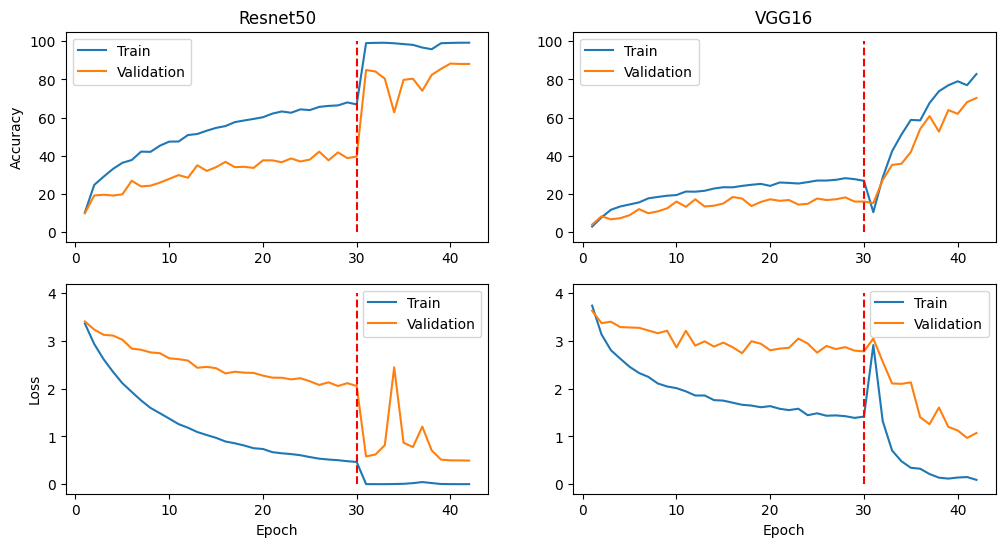

In [73]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))

ax1.plot(np.linspace(1, epochs+30, epochs+30), resnet_acc_fe["train"] + resnet_acc_ft["train"], label="Train")
ax1.plot(np.linspace(1, epochs+30, epochs+30), resnet_acc_fe["val"] + resnet_acc_ft["val"], label="Validation")
ax2.plot(np.linspace(1, epochs+30, epochs+30), vgg_acc_fe["train"] + vgg_acc_ft["train"], label="Train")
ax2.plot(np.linspace(1, epochs+30, epochs+30), vgg_acc_fe["val"] + vgg_acc_ft["val"], label="Validation")
ax3.plot(np.linspace(1, epochs+30, epochs+30), resnet_loss_fe["train"] + resnet_loss_ft["train"], label="Train")
ax3.plot(np.linspace(1, epochs+30, epochs+30), resnet_loss_fe["val"] + resnet_loss_ft["val"], label="Validation")
ax4.plot(np.linspace(1, epochs+30, epochs+30), vgg_loss_fe["train"] + vgg_loss_ft["train"], label="Train")
ax4.plot(np.linspace(1, epochs+30, epochs+30), vgg_loss_fe["val"] + vgg_loss_ft["val"], label="Validation")
ax1.set_title('Resnet50')
ax1.set_ylabel('Accuracy')
ax1.vlines(30, 0, 100, linestyles='dashed', color='red')
ax1.legend()
ax2.set_title('VGG16')
ax2.vlines(30, 0, 100, linestyles='dashed', color='red')
ax2.legend()
ax3.set_ylabel('Loss')
ax3.set_xlabel('Epoch')
ax3.vlines(30, 0, 4, linestyles='dashed', color='red')
ax3.legend()
ax4.set_xlabel('Epoch')
ax4.vlines(30, 0, 4, linestyles='dashed', color='red')
ax4.legend()
plt.show()

## 7) Confusion Matrix:

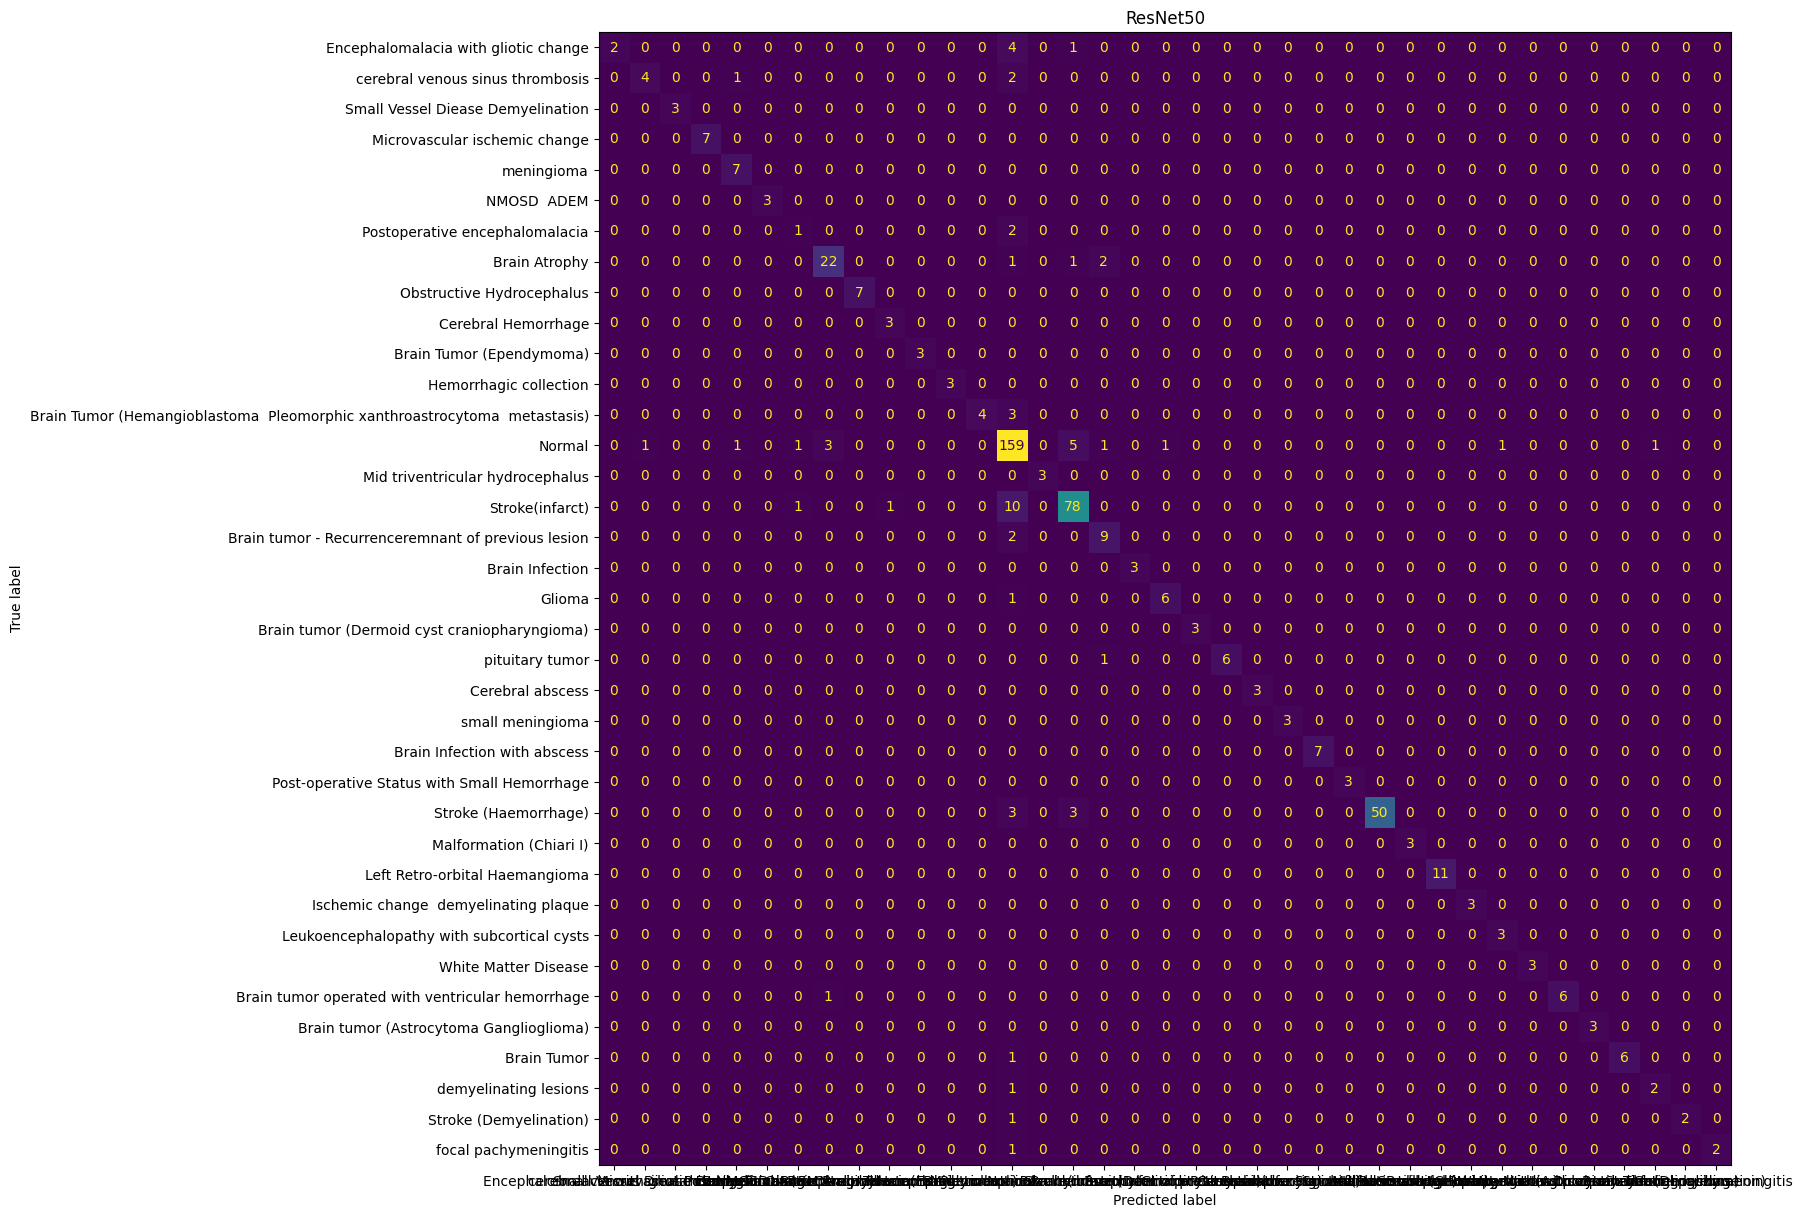

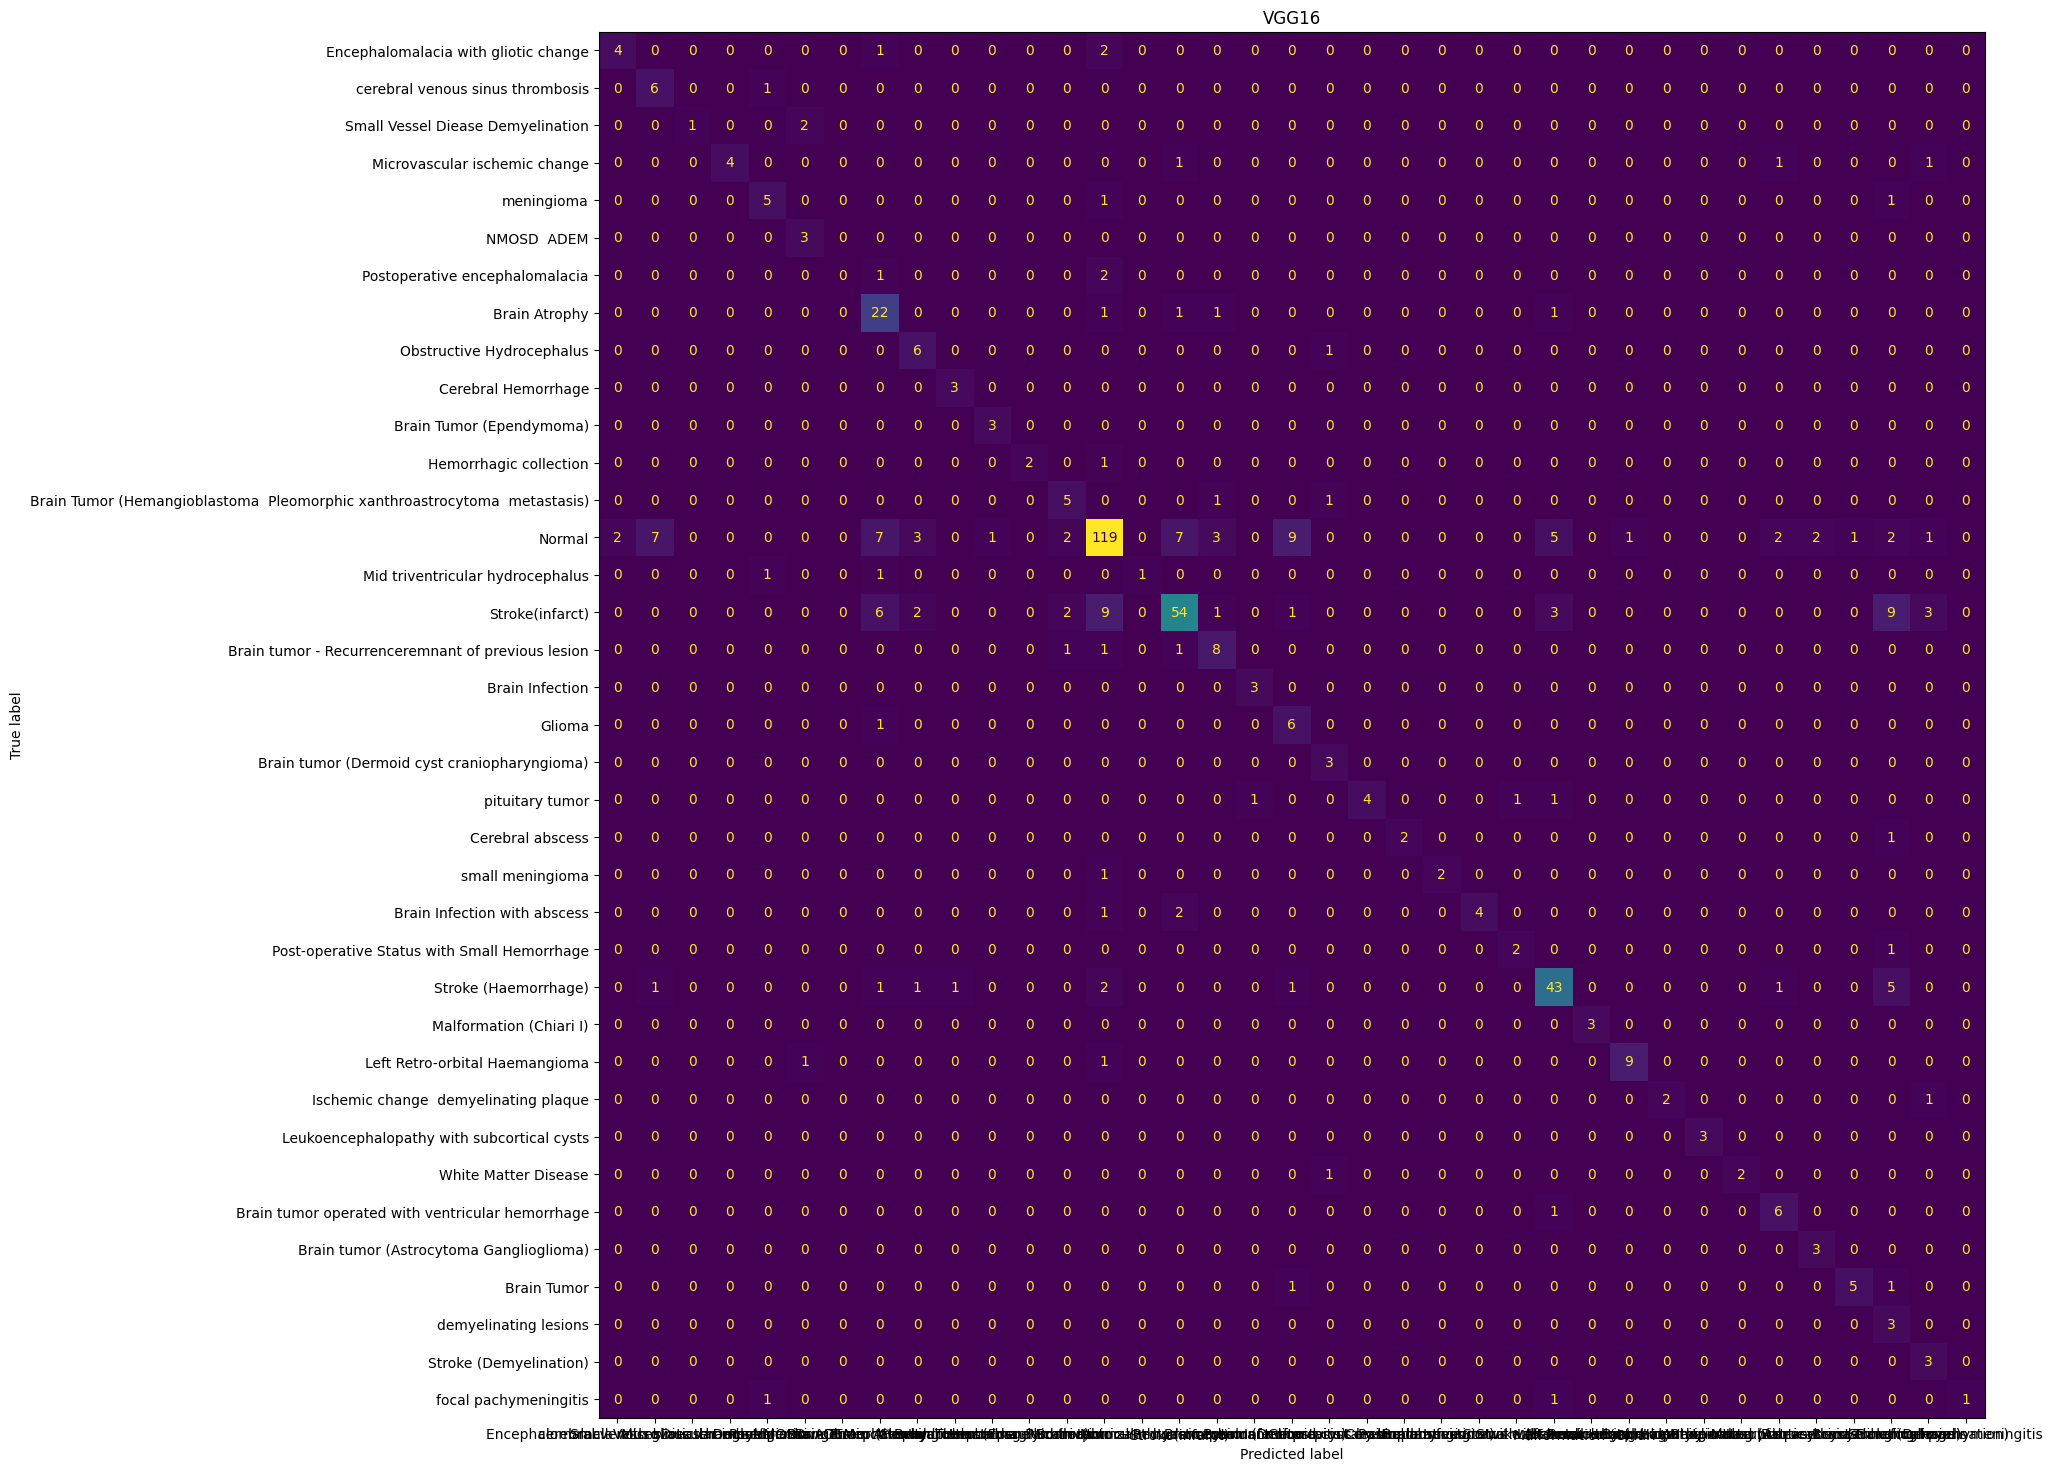

In [149]:
#resnet50
target = {'true': [], 'predict': []}

resnet_model.eval()
with torch.no_grad():
  for input, label in data_loaders['val']:
    input = input.to(device)
    pred_l = resnet_model(input)
    target['true'] += [label.item()]
    target['predict'] += [torch.argmax(pred_l).item()]

cm = confusion_matrix(target['true'], target['predict'])
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(18,18))
ax.set_title('ResNet50')
cmd.plot(ax=ax, colorbar=False)
plt.tight_layout()


#vgg16
target = {'true': [], 'predict': []}

vgg_model.eval()
with torch.no_grad():
  for input, label in data_loaders['val']:
    input = input.to(device)
    pred_l = vgg_model(input)
    target['true'] += [label.item()]
    target['predict'] += [torch.argmax(pred_l).item()]

cm = confusion_matrix(target['true'], target['predict'])
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(18,18))
ax.set_title('VGG16')
cmd.plot(ax=ax, colorbar=False)

# 9) Evaluate on Test Split:

In [158]:
res_target = {'true': [], 'predict': []}

resnet_model.eval()
with torch.no_grad():
  for input, label in test_loader:
    input = input.to(device)
    pred_l = resnet_model(input)
    res_target['true'] += [label.item()]
    res_target['predict'] += [torch.argmax(pred_l).item()]

vgg_target = {'true': [], 'predict': []}

vgg_model.eval()
with torch.no_grad():
  for input, label in test_loader:
    input = input.to(device)
    pred_l = vgg_model(input)
    vgg_target['true'] += [label.item()]
    vgg_target['predict'] += [torch.argmax(pred_l).item()]

resnet_acc = accuracy_score(res_target['true'], res_target['predict'])
vgg_acc = accuracy_score(vgg_target['true'], vgg_target['predict'])

print('Accuracy on Test Data:')
print('ResNet50:', resnet_acc)
print('VGG16:', vgg_acc)

Accuracy on Test Data:
ResNet50: 0.8594890510948905
VGG16: 0.7071167883211679


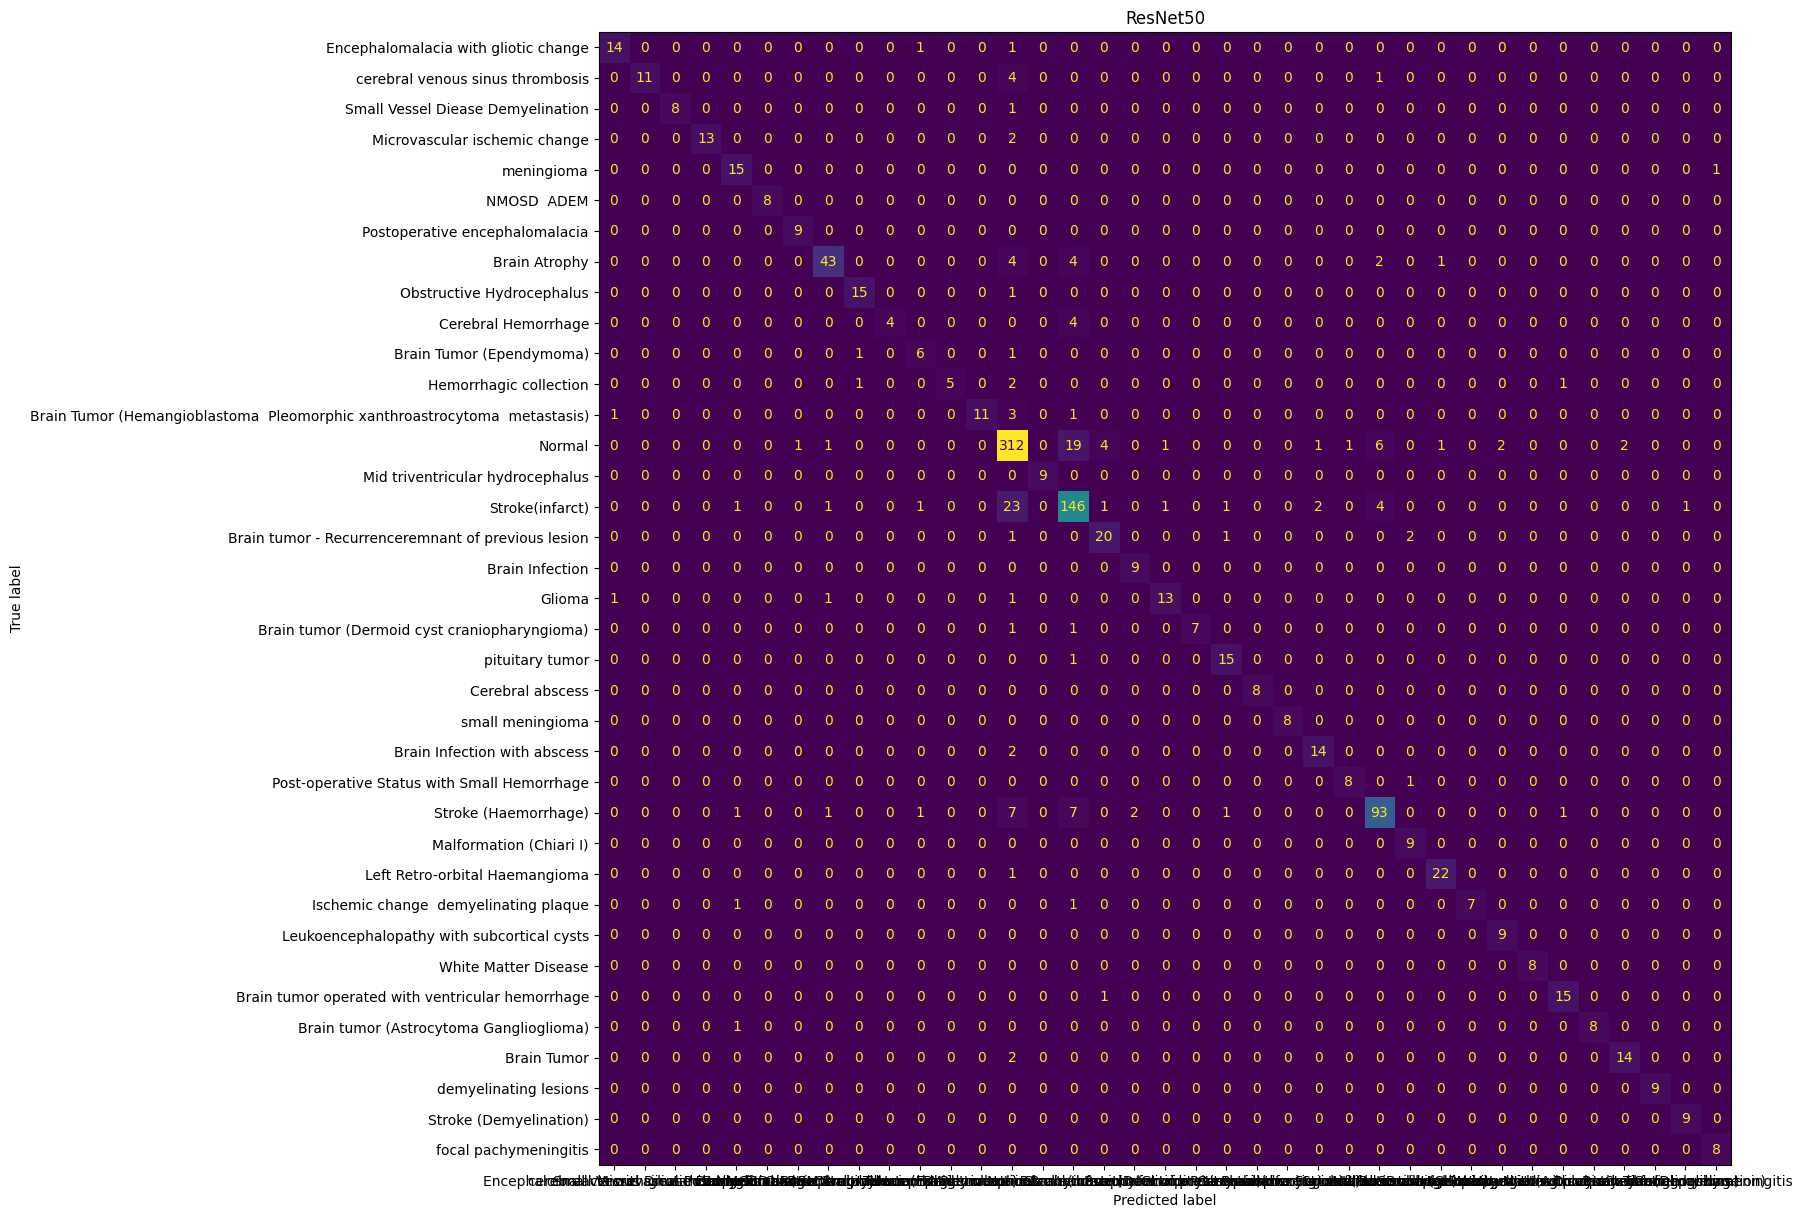

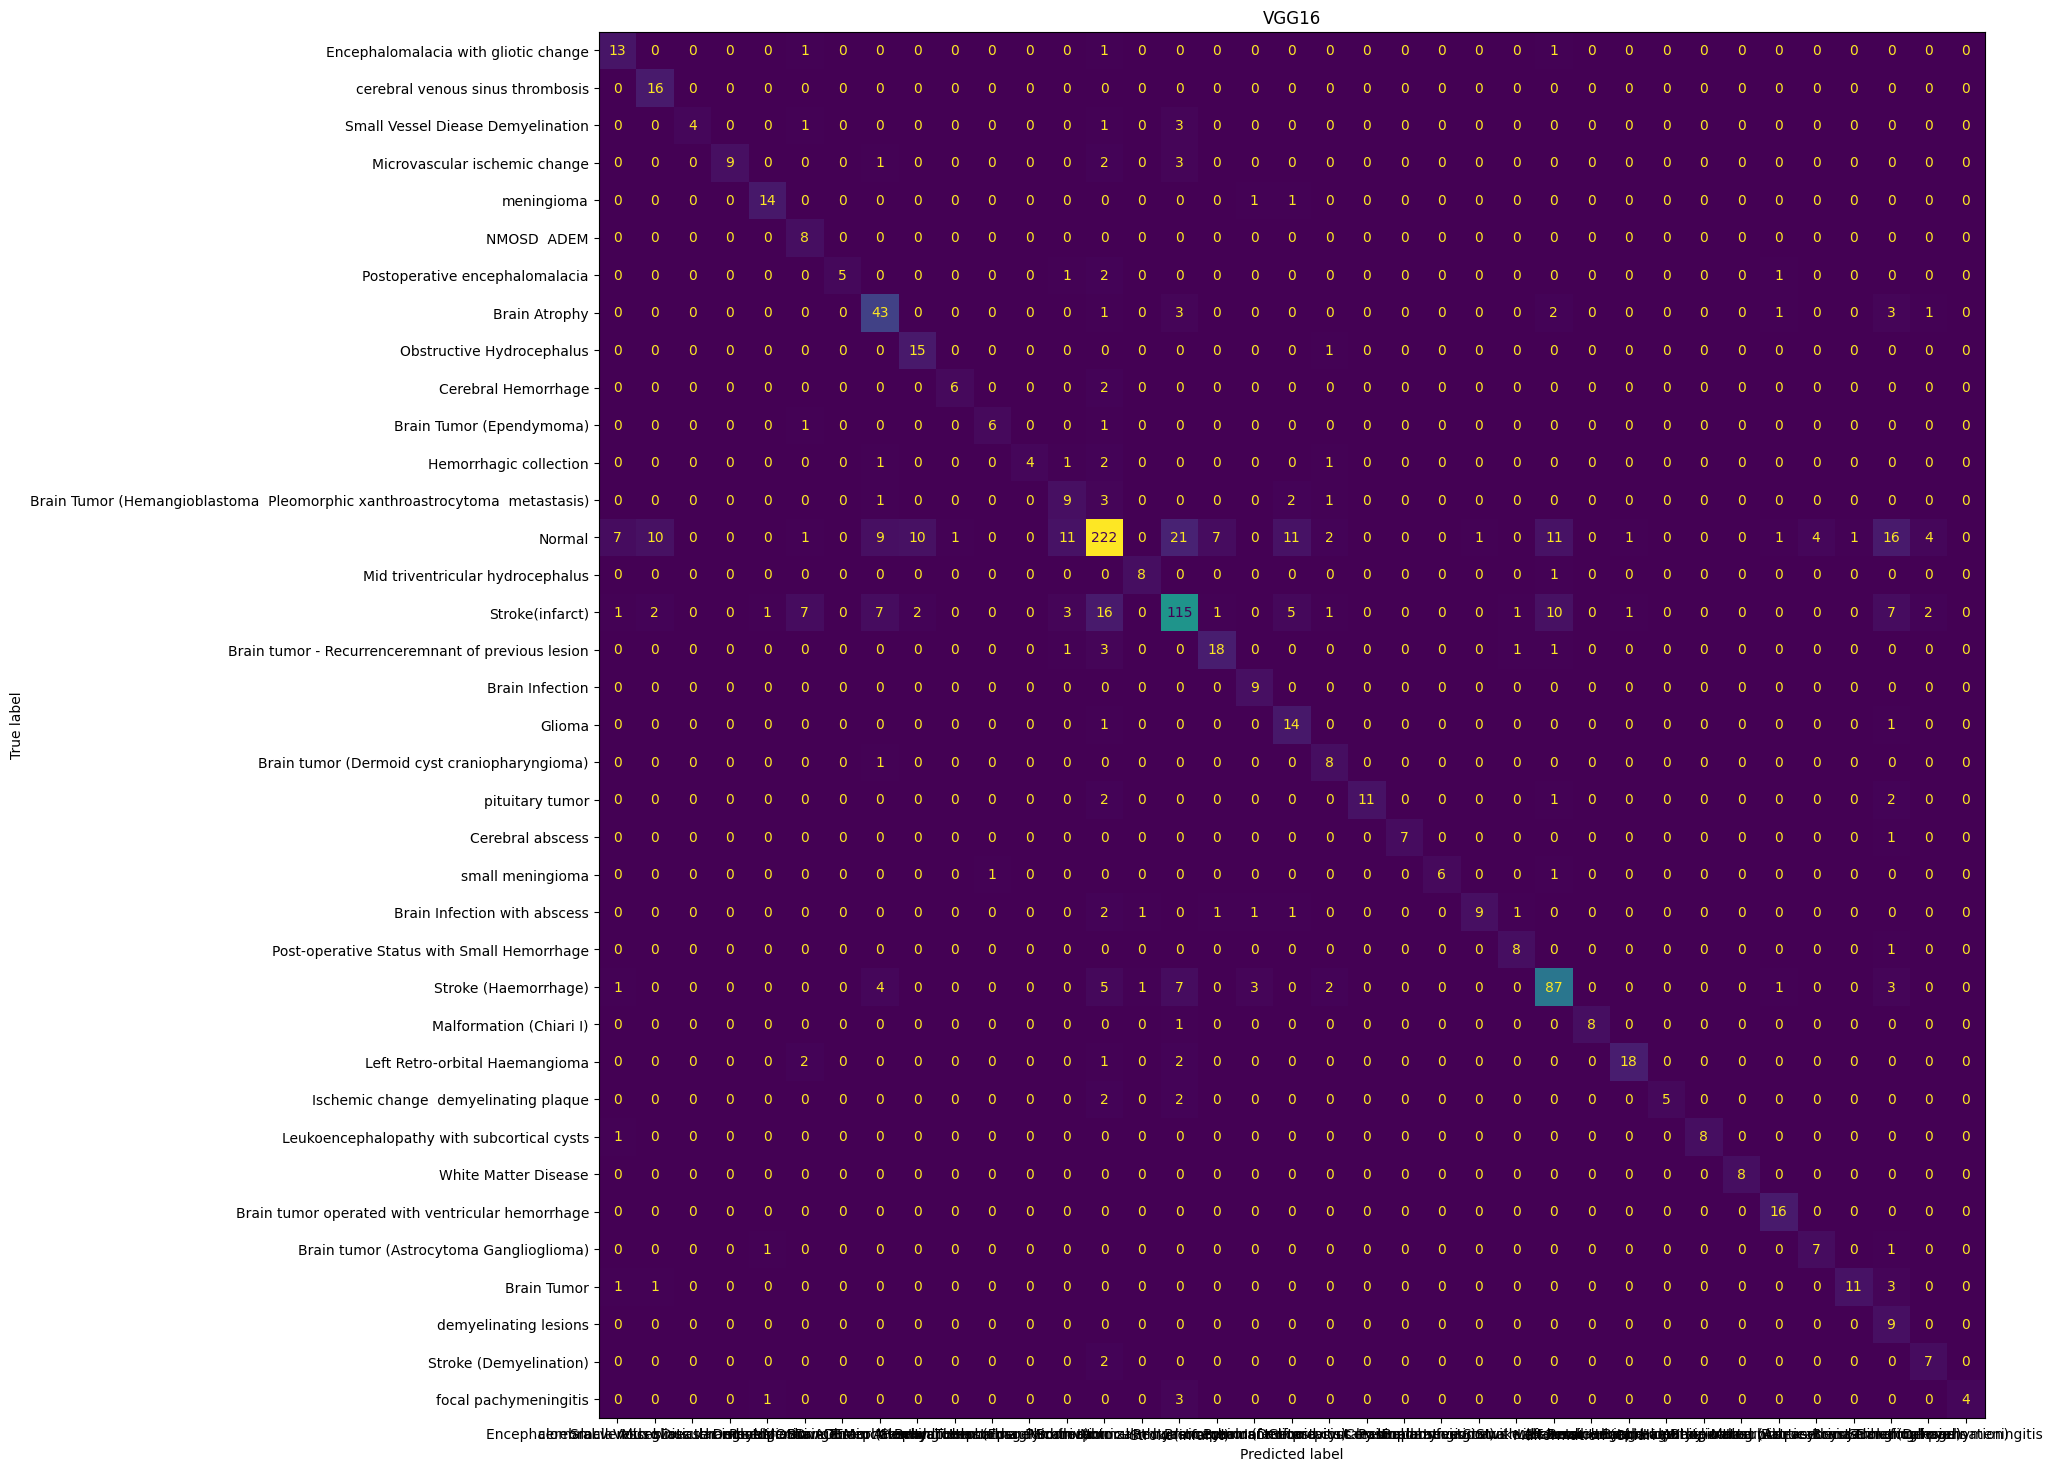

In [151]:
cm = confusion_matrix(res_target['true'], res_target['predict'])
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(18,18))
ax.set_title('ResNet50')
cmd.plot(ax=ax, colorbar=False)
plt.tight_layout()

cm = confusion_matrix(vgg_target['true'], vgg_target['predict'])
cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(18,18))
ax.set_title('VGG16')
cmd.plot(ax=ax, colorbar=False)